In [1]:
cd ..

/home/yann/IVISpaces


In [2]:
import torch
from torch import nn

from Data import get_setup
from Inference import *
from Models import get_mlp
from pylab import *
import matplotlib.pyplot as plt

In [3]:
## synthetic 1D data ##
n_epochs = 3000
num_epochs_ensemble = 3000
batch_size = 50
# predictive model architecture
layerwidth = 50
nblayers = 1
activation = nn.Tanh()

dataset = 'foong'

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
x_pred=torch.linspace(-4.,2.,500).unsqueeze(-1).to(device)

setup_ = get_setup('foong')
setup=setup_.Setup(device) 


x_train, y_train=setup.train_data()

def PlotFoong(y_pred, x_pred=x_pred,  x=x_train, y=y_train):
 
    parameters = {'axes.labelsize':18,
                  'axes.titlesize': 18,
                  'xtick.labelsize' : 15,
                  'ytick.labelsize' : 15,
                  'figure.titlesize':14}

    fig, ax=plt.subplots()
    plt.rcParams.update(parameters)
    

    x_pred=x_pred.squeeze()
    

    plt.plot(x_pred.cpu(), torch.cos(4.0*(x_pred+0.2)).cpu(),'--', linewidth=1., color='darkcyan')
    color='springgreen'#'darkgreen'#'dodgerblue'#

    ax.set_yticks([-3,0,3])
    ax.set_xticks([-3,-2,-1,0,1])
    plt.grid(True, which='major', linewidth=0.5)
    plt.ylim(-5, 5)
    plt.xlim(-4.,2.)
    plt.scatter(x.cpu(), y.cpu() , marker='.',linewidth=.5, color='black',zorder=4)
    for i in range(len(y_pred)):
        plt.plot(x_pred.cpu(), y_pred[i].cpu(), linewidth=1., label="f-{}".format(i))
    #plt.legend()
    return fig

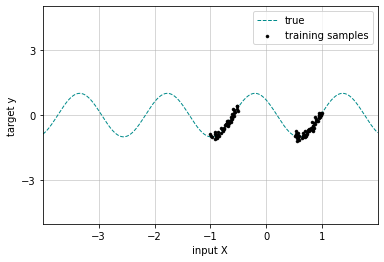

In [6]:
x_pred=x_pred  
x=x_train
y=y_train
parameters = {'axes.labelsize':12,
              'axes.titlesize': 12,
              'xtick.labelsize' : 12,
              'ytick.labelsize' : 12,
              'figure.titlesize':14}

fig, ax=plt.subplots()
plt.rcParams.update(parameters)


x_pred=x_pred.squeeze()


plt.plot(x_pred.cpu(), torch.cos(4.0*(x_pred+0.2)).cpu(),'--', linewidth=1., color='darkcyan', label="true")
color='springgreen'#'darkgreen'#'dodgerblue'#

ax.set_yticks([-3,0,3])
ax.set_xticks([-3,-2,-1,0,1])
plt.grid(True, which='major', linewidth=0.5)
plt.ylim(-5, 5)
plt.xlim(-4.,2.)
plt.xlabel("input X")
plt.ylabel("target y")
plt.scatter(x.cpu(), y.cpu() , marker='.',linewidth=.5, color='black',zorder=4, label="training samples")

plt.legend()

In [153]:
fig.savefig('trainingset.pdf', bbox_inches='tight', dpi=400)

# Ensemble

In [8]:
setup_ = get_setup(dataset)
setup = setup_.Setup(device)
x_train, y_train = setup.train_data()

model_list, time = ensemble(x_train, y_train, batch_size, layerwidth, activation, num_epochs=num_epochs_ensemble,
                            num_models=5)

EnsembleB-4: 100%|██████████| 3000/3000 [00:13<00:00, 223.96it/s, loss=0.44] 


In [10]:
y_pred = ensemble_predict(x_pred, model_list)


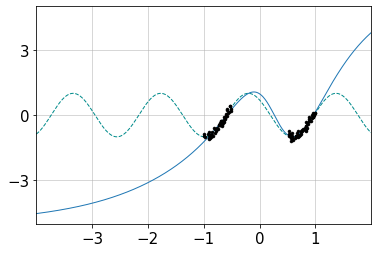

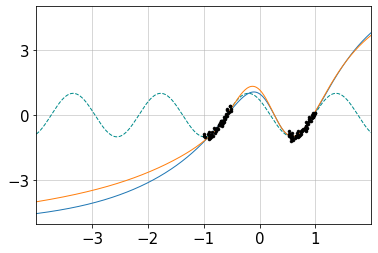

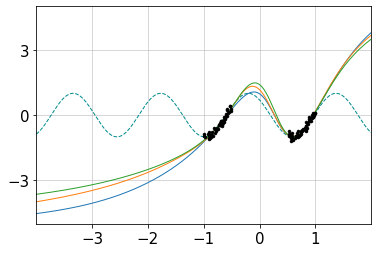

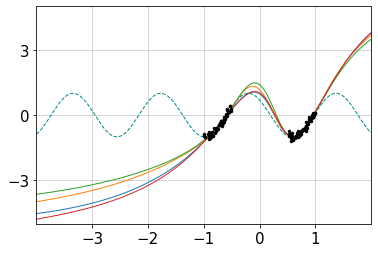

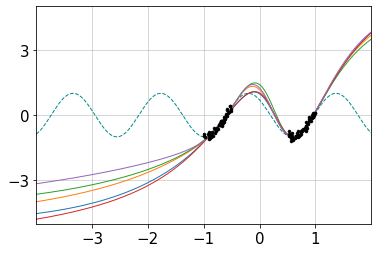

In [13]:
for i in range(5):
    fig=PlotFoong(y_pred[:i+1], x_pred=x_pred,  x=x_train, y=y_train)
    fig.savefig('Ensemble-{}.pdf'.format(i), dpi=400)

In [35]:
fig.savefig('Ensemble3.pdf', dpi=400)

In [50]:
pairs=[(0,1),(0,2),(1,2)]
sides={}
angles=[]
for i,j in pairs:
    sides.update({(i,j):(y_pred[i]-y_pred[j]).pow(2).sum(0).mul(6/len(x_pred)).sqrt().item()})
for i,j in pairs:    
    print("dist(f-{},f-{})={:.2f}".format(i,j,sides[(i,j)]))

angles=torch.Tensor(3,1)
angles[0]=np.arccos((sides[(0,1)]**2+sides[(0,2)]**2 - sides[(1,2)]**2)/(2*sides[(0,1)]*sides[(0,2)]))
angles[1]=np.arccos((sides[(0,1)]**2+sides[(1,2)]**2 - sides[(0,2)]**2)/(2*sides[(0,1)]*sides[(1,2)]))
angles[2]=np.arccos((sides[(0,2)]**2+sides[(1,2)]**2 - sides[(0,1)]**2)/(2*sides[(0,2)]*sides[(1,2)]))
angles*=(180/np.pi)
for i in range(3):
    print("angle at {}: {}".format(i, angles[i]))
print(angles.sum())

dist(f-0,f-1)=1.24
dist(f-0,f-2)=0.58
dist(f-1,f-2)=1.80
angle at 0: tensor([162.2207])
angle at 1: tensor([5.6094])
angle at 2: tensor([12.1700])
tensor(180.)


In [49]:
pairs=[(0,1),(0,2),(1,2)]
sides={}
angles=[]
thetas= [torch.cat([p.view(-1) for p in list(model_list[i].parameters())]) for i in range(3)]


for i,j in pairs:
    sides.update({(i,j):(thetas[i]-thetas[j]).pow(2).sum(0).sqrt().item()})
for i,j in pairs:    
    print("dist(f-{},f-{})={:.2f}".format(i,j,sides[(i,j)]))

angles=torch.Tensor(3,1)
angles[0]=np.arccos((sides[(0,1)]**2+sides[(0,2)]**2 - sides[(1,2)]**2)/(2*sides[(0,1)]*sides[(0,2)]))
angles[1]=np.arccos((sides[(0,1)]**2+sides[(1,2)]**2 - sides[(0,2)]**2)/(2*sides[(0,1)]*sides[(1,2)]))
angles[2]=np.arccos((sides[(0,2)]**2+sides[(1,2)]**2 - sides[(0,1)]**2)/(2*sides[(0,2)]*sides[(1,2)]))
angles*=(180/np.pi)
for i in range(3):
    print("angle at {}: {}".format(i, angles[i]))
print(angles.sum())

dist(f-0,f-1)=11.67
dist(f-0,f-2)=10.22
dist(f-1,f-2)=10.69
angle at 0: tensor([58.0176])
angle at 1: tensor([54.1920])
angle at 2: tensor([67.7904])
tensor(180.)


# NN-HyVI

In [50]:
setup_ = get_setup(dataset)
setup = setup_.Setup(device)
x_train, y_train = setup.train_data()

setup_ = get_setup(dataset)
setup = setup_.Setup(device)
x_train, y_train = setup.train_data()



gen, model, sigma_noise, time = NN_HyVI(x_train, y_train, batch_size,
                                          layerwidth, nblayers, activation,
                                          n_epochs=n_epochs, sigma_noise_init=setup.sigma_noise,
                                          learn_noise=False)



NN-HyVI:  31%|███       | 932/3000 [00:17<00:38, 54.35it/s, ELBO=44.9, KL=204, LogLike=31.7, lr=0.0001, sigma=0.1]    


In [54]:
theta = gen(5).detach()
y_pred = model(x_pred, theta)


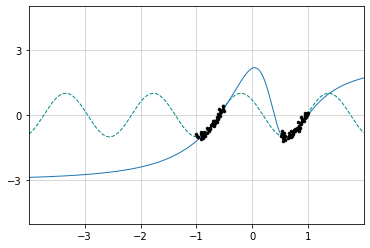

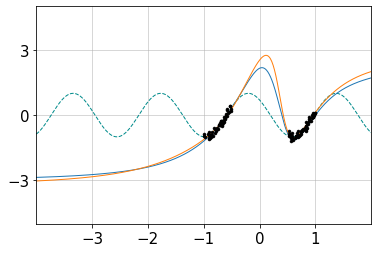

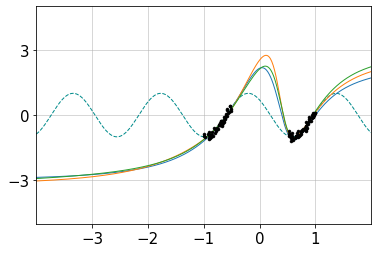

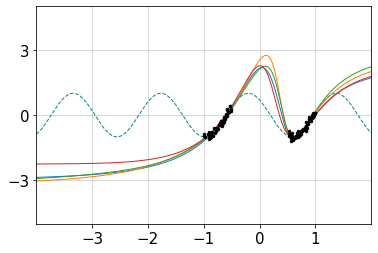

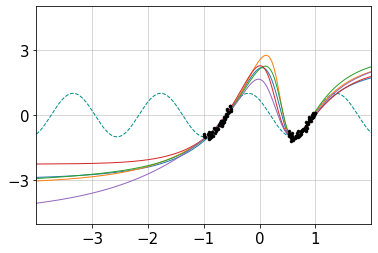

In [55]:
for i in range(5):
    fig=PlotFoong(y_pred[:i+1], x_pred=x_pred,  x=x_train, y=y_train)
    fig.savefig('NN-HyVI-{}.pdf'.format(i), dpi=400)

# FuNN-HyVI

In [7]:
setup_ = get_setup(dataset)
setup = setup_.Setup(device)
x_train, y_train = setup.train_data()

setup_ = get_setup(dataset)
setup = setup_.Setup(device)
x_train, y_train = setup.train_data()

def input_sampler(n_ood=50):
    M = -4.
    m = 2.
    X = torch.rand(n_ood, 1).to(device) * (M - m) + m
    return X

gen, model, sigma_noise, time = FuNN_HyVI(x_train, y_train, batch_size,
                                          layerwidth, nblayers, activation,
                                          input_sampler, n_epochs=n_epochs, sigma_noise_init=setup.sigma_noise,
                                          learn_noise=False)



FuNN-HyVI:  30%|███       | 915/3000 [00:19<00:43, 47.73it/s, ELBO=-2.71, KL=76.5, LogLike=31.6, lr=0.0001, sigma=0.1]   


In [13]:
theta = gen(5).detach()
y_pred = model(x_pred, theta)


In [ ]:
for i in range(5):
    fig=PlotFoong(y_pred[:i+1], x_pred=x_pred,  x=x_train, y=y_train)
    fig.savefig('FuNN-HyVI-{}.pdf'.format(i), dpi=400)

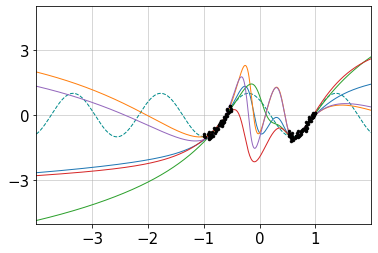

In [14]:
fig=PlotFoong(y_pred, x_pred=x_pred,  x=x_train, y=y_train)

In [134]:
fig.savefig('FuNN-HyVI3.pdf', dpi=400)

In [135]:
thetas=theta[[0,1,5]]

In [136]:
pairs=[(0,1),(0,2),(1,2)]
sides={}
angles=[]


for i,j in pairs:
    sides.update({(i,j):(thetas[i]-thetas[j]).pow(2).sum(0).sqrt().item()})
for i,j in pairs:    
    print("dist(f-{},f-{})={:.2f}".format(i,j,sides[(i,j)]))

angles=torch.Tensor(3,1)
angles[0]=np.arccos((sides[(0,1)]**2+sides[(0,2)]**2 - sides[(1,2)]**2)/(2*sides[(0,1)]*sides[(0,2)]))
angles[1]=np.arccos((sides[(0,1)]**2+sides[(1,2)]**2 - sides[(0,2)]**2)/(2*sides[(0,1)]*sides[(1,2)]))
angles[2]=np.arccos((sides[(0,2)]**2+sides[(1,2)]**2 - sides[(0,1)]**2)/(2*sides[(0,2)]*sides[(1,2)]))
angles*=(180/np.pi)
for i in range(3):
    print("angle at {}: {}".format(i, angles[i]))
print(angles.sum())

dist(f-0,f-1)=2.21
dist(f-0,f-2)=6.37
dist(f-1,f-2)=6.99
angle at 0: tensor([96.8800])
angle at 1: tensor([64.8538])
angle at 2: tensor([18.2662])
tensor(180.)


In [137]:
pairs=[(0,1),(0,2),(1,2)]
sides={}
angles=[]
for i,j in pairs:
    sides.update({(i,j):(y_pred[i]-y_pred[j]).pow(2).sum(0).mul(6/len(x_pred)).sqrt().item()})
for i,j in pairs:    
    print("dist(f-{},f-{})={:.2f}".format(i,j,sides[(i,j)]))

angles=torch.Tensor(3,1)
angles[0]=np.arccos((sides[(0,1)]**2+sides[(0,2)]**2 - sides[(1,2)]**2)/(2*sides[(0,1)]*sides[(0,2)]))
angles[1]=np.arccos((sides[(0,1)]**2+sides[(1,2)]**2 - sides[(0,2)]**2)/(2*sides[(0,1)]*sides[(1,2)]))
angles[2]=np.arccos((sides[(0,2)]**2+sides[(1,2)]**2 - sides[(0,1)]**2)/(2*sides[(0,2)]*sides[(1,2)]))
angles*=(180/np.pi)
for i in range(3):
    print("angle at {}: {}".format(i, angles[i]))
print(angles.sum())

dist(f-0,f-1)=2.39
dist(f-0,f-2)=6.17
dist(f-1,f-2)=4.27
angle at 0: tensor([29.9059])
angle at 1: tensor([133.9077])
angle at 2: tensor([16.1864])
tensor(180.0000)


# MC Dropout

In [23]:
setup_ = get_setup(dataset)
setup = setup_.Setup(device)
x_train, y_train = setup.train_data()
batch_size = len(x_train)

model = MC_Dropout(x_train, y_train, batch_size, layerwidth, init_sigma_noise=setup.sigma_noise, drop_prob=0.05,
                   learn_noise=False,
                   activation=activation)

weight_decay = 1e-1 / (10 * len(x_train) // 9) ** 0.5
_ = model.fit(num_epochs=n_epochs, learn_rate=1e-3, weight_decay=weight_decay)

y_pred_, sigma_noise = model.predict(x_pred, 1000)
y_mean = y_pred_.mean(axis=0)
y_sigma = y_pred_.std(axis=0)
y_pred = y_mean + y_sigma * torch.randn(1000, len(x_pred), 1).to(device) \
         + setup.sigma_noise * torch.randn(1000, len(x_pred), 1).to(device)

MCdropout: 100%|██████████| 3000/3000 [00:10<00:00, 281.61it/s, loss=-.25, sigma_noise=0.1]  


In [26]:
x_test, y_test = setup.test_data()
y_pred, sigma_noise = model.predict(x_pred, 1000)

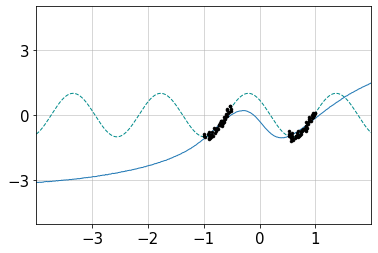

In [27]:
fig=PlotFoong(y_pred.mean(0).unsqueeze(0), x_pred=x_pred,  x=x_train, y=y_train)

In [28]:
fig.savefig('MCDrpout-00.pdf', dpi=400)

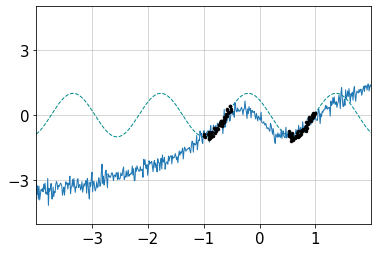

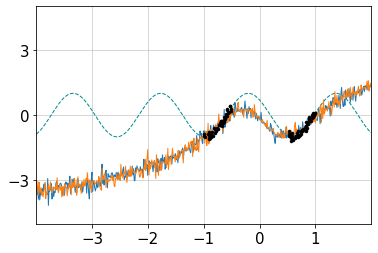

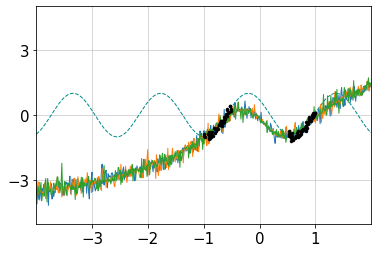

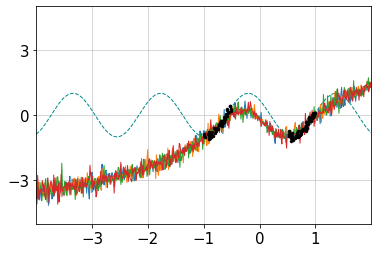

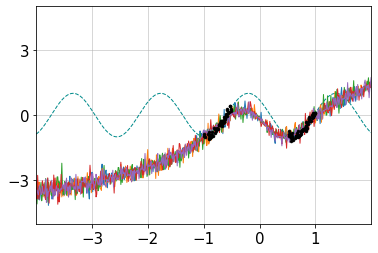

In [21]:
for i in range(5):
    fig=PlotFoong(y_pred[:i+1], x_pred=x_pred,  x=x_train, y=y_train)
    fig.savefig('MCDrpout-{}.pdf'.format(i), dpi=400)

# MFVI

In [7]:
setup_ = get_setup(dataset)
setup = setup_.Setup(device)
x_train, y_train = setup.train_data()

MF_dist, model, sigma_noise, time = MFVI(x_train, y_train, batch_size,
                                         layerwidth, nblayers, activation,
                                         n_epochs=n_epochs, sigma_noise_init=setup.sigma_noise,
                                         learn_noise=False)



MFVI:  54%|█████▍    | 1628/3000 [00:26<00:22, 61.14it/s, ELBO=135, KL=402, LogLike=16, lr=0.0001, sigma=0.1]      


In [19]:
#theta = MF_dist(5).detach()
y_pred = model(x_pred, thetas)


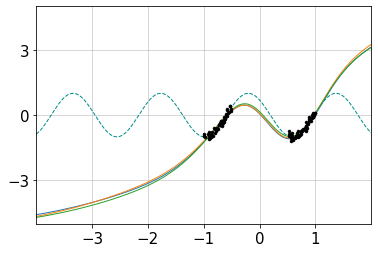

In [20]:
fig=PlotFoong(y_pred, x_pred=x_pred,  x=x_train, y=y_train)

In [21]:
fig.savefig('MFVI3.pdf', dpi=400)

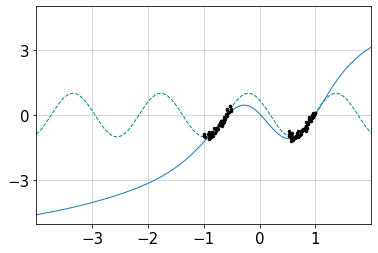

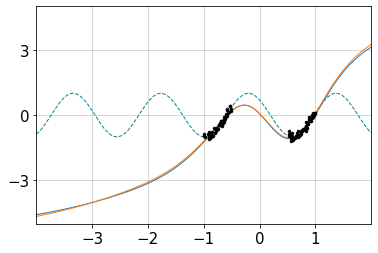

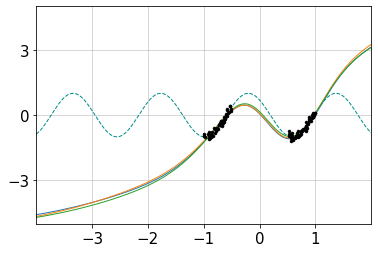

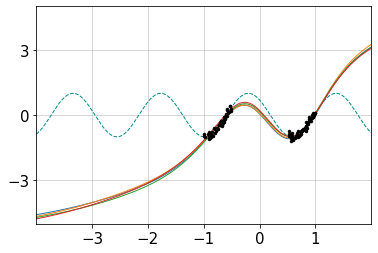

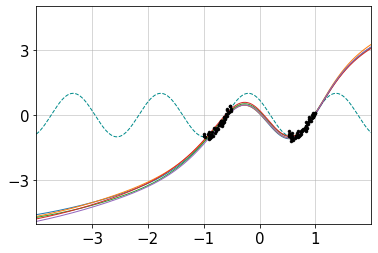

In [15]:
for i in range(5):
    fig=PlotFoong(y_pred[:i+1], x_pred=x_pred,  x=x_train, y=y_train)
    fig.savefig('MFVI-{}.pdf'.format(i), dpi=400)

In [16]:
thetas=theta[:3]

In [17]:
pairs=[(0,1),(0,2),(1,2)]
sides={}
angles=[]


for i,j in pairs:
    sides.update({(i,j):(thetas[i]-thetas[j]).pow(2).sum(0).sqrt().item()})
for i,j in pairs:    
    print("dist(f-{},f-{})={:.2f}".format(i,j,sides[(i,j)]))

angles=torch.Tensor(3,1)
angles[0]=np.arccos((sides[(0,1)]**2+sides[(0,2)]**2 - sides[(1,2)]**2)/(2*sides[(0,1)]*sides[(0,2)]))
angles[1]=np.arccos((sides[(0,1)]**2+sides[(1,2)]**2 - sides[(0,2)]**2)/(2*sides[(0,1)]*sides[(1,2)]))
angles[2]=np.arccos((sides[(0,2)]**2+sides[(1,2)]**2 - sides[(0,1)]**2)/(2*sides[(0,2)]*sides[(1,2)]))
angles*=(180/np.pi)
for i in range(3):
    print("angle at {}: {}".format(i, angles[i]))
print(angles.sum())

dist(f-0,f-1)=2.32
dist(f-0,f-2)=2.93
dist(f-1,f-2)=2.49
angle at 0: tensor([55.2733])
angle at 1: tensor([74.8962])
angle at 2: tensor([49.8305])
tensor(180.)


In [18]:
pairs=[(0,1),(0,2),(1,2)]
sides={}
angles=[]
for i,j in pairs:
    sides.update({(i,j):(y_pred[i]-y_pred[j]).pow(2).sum(0).mul(6/len(x_pred)).sqrt().item()})
for i,j in pairs:    
    print("dist(f-{},f-{})={:.2f}".format(i,j,sides[(i,j)]))

angles=torch.Tensor(3,1)
angles[0]=np.arccos((sides[(0,1)]**2+sides[(0,2)]**2 - sides[(1,2)]**2)/(2*sides[(0,1)]*sides[(0,2)]))
angles[1]=np.arccos((sides[(0,1)]**2+sides[(1,2)]**2 - sides[(0,2)]**2)/(2*sides[(0,1)]*sides[(1,2)]))
angles[2]=np.arccos((sides[(0,2)]**2+sides[(1,2)]**2 - sides[(0,1)]**2)/(2*sides[(0,2)]*sides[(1,2)]))
angles*=(180/np.pi)
for i in range(3):
    print("angle at {}: {}".format(i, angles[i]))
print(angles.sum())

dist(f-0,f-1)=0.13
dist(f-0,f-2)=0.22
dist(f-1,f-2)=0.25
angle at 0: tensor([84.9619])
angle at 1: tensor([62.2778])
angle at 2: tensor([32.7603])
tensor(180.0000)


In [22]:
setup_ = get_setup('protein')
setup=setup_.Setup(device) 

In [23]:
x,y=setup.train_data()

(-3.1791319847106934, 6.291660308837891)

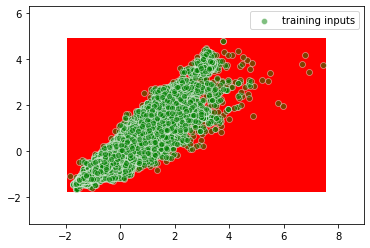

In [48]:
import seaborn as sns

fig, ax=subplots()
ax=sns.scatterplot(x[:,0].cpu(),x[:,3].cpu(), label='training inputs', zorder=1, alpha=0.5,color='green', ax=ax)
x_min=x[:,0].min().cpu()
y_min=x[:,3].min().cpu()
x_range=x[:,0].max().cpu()-x_min
y_range=x[:,3].max().cpu()-y_min
ax.add_patch(Rectangle((x_min, y_min), x_range, y_range,
             edgecolor = 'red',
             facecolor = 'red',
             zorder=0,
             fill=True,
             lw=6))
plt.xlim(x_min-1.5,x_min+x_range+1.5)
plt.ylim(y_min-1.5,y_min+y_range+1.5)

In [49]:
fig.savefig("OOD.pdf", dpi=400)